# Demo DDIM with Jump Technique

This notebook demonstrates the use of the DDIM with a special feature, which is prediction $x_0$ from any abitrary $x_t$. The detailed description can be found in this blog post: [https://tuananhbui89.github.io/blog/2023/diffusion-tutorial-p2/](https://tuananhbui89.github.io/blog/2023/diffusion-tutorial-p2/)

In [12]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
import torch
from PIL import Image
import pandas as pd
import argparse
import os
import numpy as np

In [ ]:
# set random seed
seed = 20231001
np.random.seed(20231001)
torch.manual_seed(20231001)

In [ ]:
def generate_images_jump(model_name, prompt, save_path, device='cuda:0', guidance_scale = 7.5, image_size=512, ddim_steps=100, num_samples=10):
    '''
    Function to generate images from diffusers code
    
    The program requires the prompts to be in a csv format with headers 
        1. 'case_number' (used for file naming of image)
        2. 'prompt' (the prompt used to generate image)
        3. 'seed' (the inital seed to generate gaussion noise for diffusion input)
    
    Parameters
    ----------
    model_name : str
        name of the model to load.
    prompt : str
        A prompt used to generate image.
    save_path : str
        save directory for images.
    device : str, optional
        device to be used to load the model. The default is 'cuda:0'.
    guidance_scale : float, optional
        guidance value for inference. The default is 7.5.
    image_size : int, optional
        image size. The default is 512.
    ddim_steps : int, optional
        number of denoising steps. The default is 100.
    num_samples : int, optional
        number of samples generated per prompt. The default is 10.

    Returns
    -------
    None.

    '''
    if model_name == 'SD-v1-4':
        dir_ = "CompVis/stable-diffusion-v1-4"
    elif model_name == 'SD-V2':
        dir_ = "stabilityai/stable-diffusion-2-base"
    elif model_name == 'SD-V2-1':
        dir_ = "stabilityai/stable-diffusion-2-1-base"
    else:
        dir_ = "CompVis/stable-diffusion-v1-4" # all the erasure models built on SDv1-4
        
    # 1. Load the autoencoder model which will be used to decode the latents into image space.
    vae = AutoencoderKL.from_pretrained(dir_, subfolder="vae")
    # 2. Load the tokenizer and text encoder to tokenize and encode the text.
    tokenizer = CLIPTokenizer.from_pretrained(dir_, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(dir_, subfolder="text_encoder")
    # 3. The UNet model for generating the latents.
    unet = UNet2DConditionModel.from_pretrained(dir_, subfolder="unet")
    if 'SD' not in model_name:
        try:
            model_path = f'models/{model_name}/{model_name.replace("compvis","diffusers")}.pt'
            unet.load_state_dict(torch.load(model_path))
        except Exception as e:
            print(f'Model path is not valid, please check the file name and structure: {e}')
            exit()
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

    vae.to(device)
    text_encoder.to(device)
    unet.to(device)
    torch_device = device

    folder_path = f'{save_path}/{model_name}'
    os.makedirs(folder_path, exist_ok=True)
    os.makedirs(f'{folder_path}/demo_jump', exist_ok=True)

    print(prompt)
    prompt = [str(prompt)]*num_samples

    height = image_size                        # default height of Stable Diffusion
    width = image_size                         # default width of Stable Diffusion

    num_inference_steps = ddim_steps           # Number of denoising steps

    guidance_scale = guidance_scale            # Scale for classifier-free guidance

    generator = torch.manual_seed(seed)        # Seed generator to create the inital latent noise

    batch_size = len(prompt)

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)

    scheduler.set_timesteps(num_inference_steps)

    latents = latents * scheduler.init_noise_sigma

    from tqdm.auto import tqdm

    scheduler.set_timesteps(num_inference_steps)

    def gen_images(latents, stop_timestep, suffix=""):
        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        for num, im in enumerate(pil_images):
            im.save(f"{folder_path}/demo_jump/" + "{:03d}_{:03d}_{}.png".format(stop_timestep, num, suffix))

    # random a timestep to stop at, so that we can predict the image at that timestep
    # note 1: the scheduler.timesteps is in reverse order, i.e., [999, 998, ..., 1, 0] if num_inference_steps=1000 
    # note 2: if num_inference_steps = 100, then the scheduler.timesteps is [999, 989, 979, ..., 19, 9, 0]
    count_timestep = num_inference_steps

    # check the order of alphas_cumprod in decreasing order
    # print(scheduler.alphas_cumprod)
    assert scheduler.alphas_cumprod[0] > scheduler.alphas_cumprod[-1]

    for t in tqdm(scheduler.timesteps):
        count_timestep -= 1
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # Predict the latent code $$z_0$$ from $$z_t$$
        # $$\tilde{z}_0 = \frac{z_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(z_t, t, \tau(c))}{\sqrt{\bar{\alpha}_t}}$$
        alpha_bar_t = scheduler.alphas_cumprod[count_timestep]

        latents_pred = (latents - torch.sqrt(1 - alpha_bar_t) * noise_pred)/ torch.sqrt(alpha_bar_t)

        # generate image from latents_pred
        gen_images(latents_pred, count_timestep, suffix="pred")

        # generate image from the current latents
        gen_images(latents, count_timestep, suffix="curr")

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # generate image from latents
    gen_images(latents, 0)

In [1]:
model_name = 'SD-v1-4' # name of model
prompt = 'Image of cassette player'
save_path = 'evaluation_folder'
device = 'cuda:0'
guidance_scale = 7.5 # 'guidance value for inference'
image_size = 512 # 'image size'
ddim_steps = 100 # 'number of denoising steps'
num_samples= 1 # 'number of samples per prompt'

In [ ]:
generate_images_jump(model_name, prompt, save_path, device=device,
                guidance_scale = guidance_scale, image_size=image_size, ddim_steps=ddim_steps, num_samples=num_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


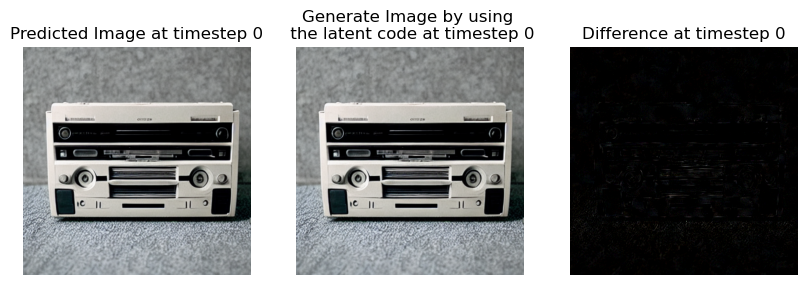

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


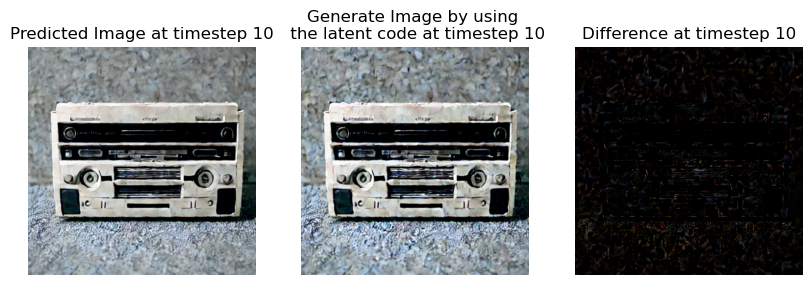

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


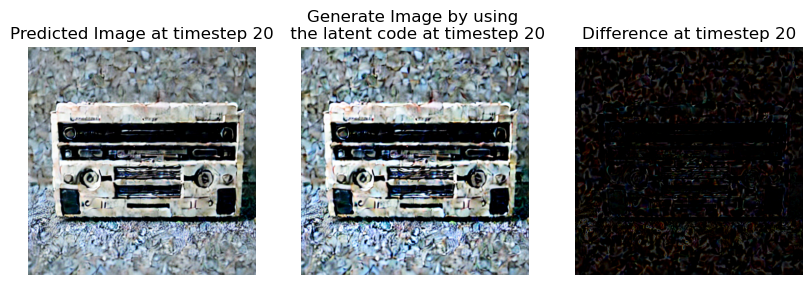

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


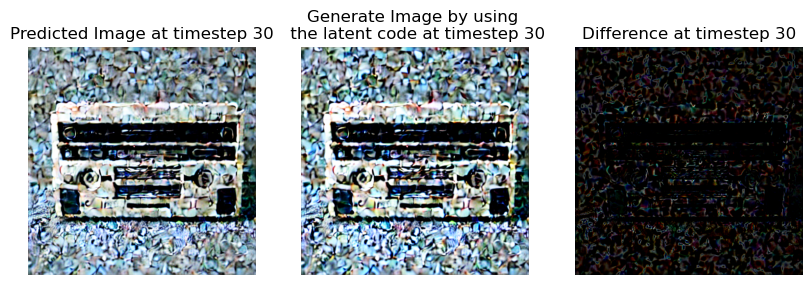

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


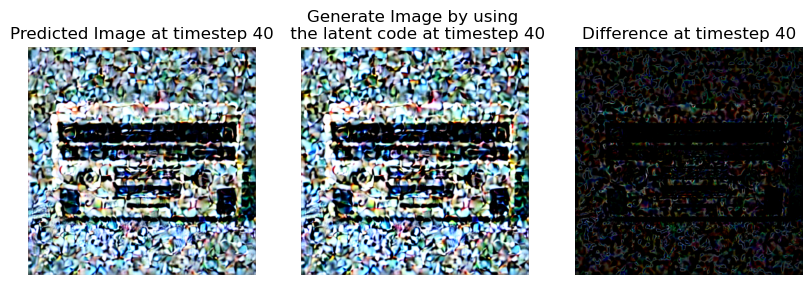

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


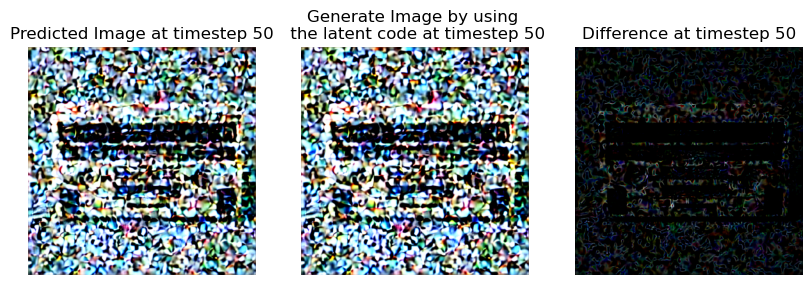

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


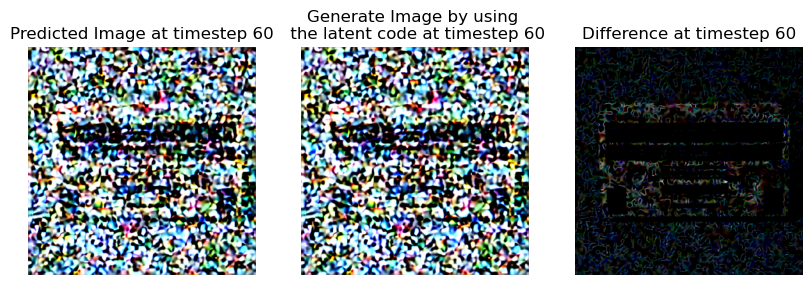

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


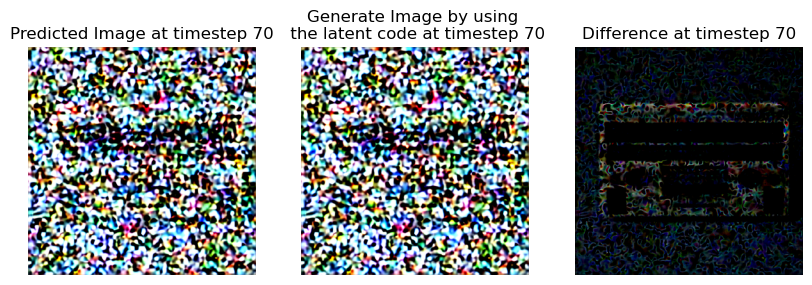

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


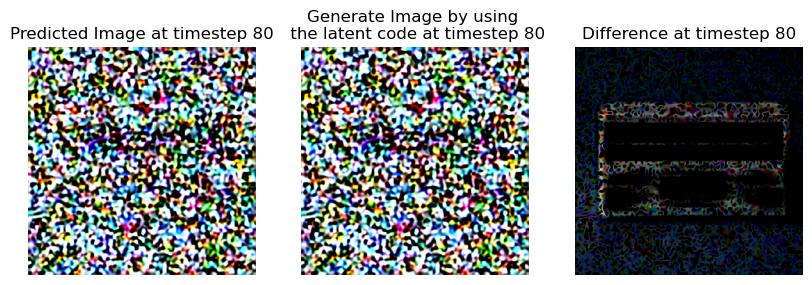

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


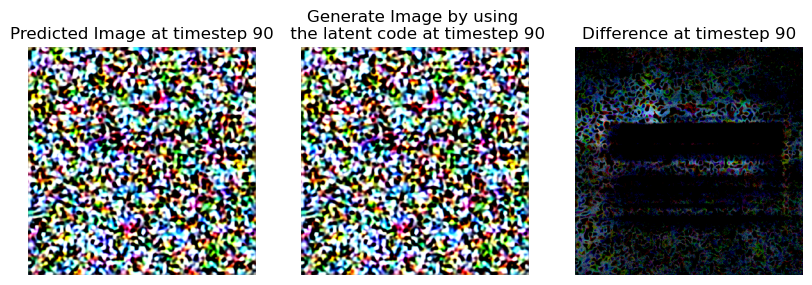

In [22]:
# showing the generated images side by side with corresponding timestep
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

timesteps = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

for t in timesteps:
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(mpimg.imread(f'{save_path}/{model_name}/demo_jump/{t:03d}_000_pred.png'))
    ax[0].set_title(f'Predicted Image at timestep {t}')
    ax[1].imshow(mpimg.imread(f'{save_path}/{model_name}/demo_jump/{t:03d}_000_curr.png'))
    ax[1].set_title(f'Generate Image by using \n the latent code at timestep {t}')
    # different between the two images with scale to better visualize
    diff = mpimg.imread(f'{save_path}/{model_name}/demo_jump/{t:03d}_000_pred.png')-mpimg.imread(f'{save_path}/{model_name}/demo_jump/{t:03d}_000_curr.png')
    diff = diff/np.max(diff)
    ax[2].imshow(diff)
    ax[2].set_title(f'Difference at timestep {t}')

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()
